In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
from sklearn.cluster import KMeans

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class HyperspectralDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.mat')]
        self.mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.mat')]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load hyperspectral image
        image_file = self.image_files[idx]
        filename = os.path.splitext(image_file)[0]
        image_path = os.path.join(self.images_dir, image_file)
        image_data = loadmat(image_path)
        image = image_data[filename] 

        # Load masks
        mask_file = self.mask_files[idx]
        mask_path = os.path.join(self.masks_dir, mask_file)
        mask_data = loadmat(mask_path)
        mask = mask_data['image']  

        # Convert to float32 and normalize
        image = image.astype(np.float32)
        image = image / np.max(image)  # Normalization

        # Convert to torch tensors
        image = torch.tensor(image).permute(2, 0, 1) # Changing shape to (C, H, W)
        mask = torch.tensor(mask).permute(2, 0, 1)   # Changging shape to (C, H, W)

        return image, mask


In [4]:
#directery
images_dir = 'DATASET_UAS/IMAGES'
masks_dir = 'DATASET_UAS/MASKS'

#converting to dataset and dataloader
dataset = HyperspectralDataset(images_dir, masks_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [5]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(30, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 30, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class SegmentationCNN(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(30, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = DenoisingCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [8]:
def segment_image(denoised_image, num_segments=5):
    # Reshape the image to (height * width, channels)
    flat_image = denoised_image.reshape(-1, denoised_image.shape[-1])
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_segments, random_state=42)
    labels = kmeans.fit_predict(flat_image)
    
    # Reshape labels back to image shape
    segmented_image = labels.reshape(denoised_image.shape[:-1])
    
    return segmented_image

In [9]:
def visualize_results(original, denoised, segmented):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display original image (using first 3 channels for RGB representation)
    axs[0].imshow(original[:,:,:3])
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    # Display denoised image (using first 3 channels for RGB representation)
    axs[1].imshow(denoised[:,:,:3])
    axs[1].set_title('Denoised')
    axs[1].axis('off')
    
    # Display segmented image
    axs[2].imshow(segmented, cmap='viridis')
    axs[2].set_title('Segmented')
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [10]:
num_epochs = 10
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        if images is None or masks is None:
            continue

        images = images.to(device)
        masks = masks.to(device)
         # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
         # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        for images, masks in dataloader:
            if images is None or masks is None:
                continue
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            validation_loss += loss.item()
        avg_val_loss = validation_loss / len(dataloader)
        print(f'Validation Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break


Epoch [1/10], Loss: 0.0418
Validation Loss: 0.0231
Epoch [2/10], Loss: 0.0177
Validation Loss: 0.0146
Epoch [3/10], Loss: 0.0149
Validation Loss: 0.0127
Epoch [4/10], Loss: 0.0127
Validation Loss: 0.0125
Epoch [5/10], Loss: 0.0128
Validation Loss: 0.0128
Epoch [6/10], Loss: 0.0113
Validation Loss: 0.0106
Epoch [7/10], Loss: 0.0100
Validation Loss: 0.0076
Epoch [8/10], Loss: 0.0079
Validation Loss: 0.0091
Epoch [9/10], Loss: 0.0064
Validation Loss: 0.0055
Epoch [10/10], Loss: 0.0047
Validation Loss: 0.0046


C:\Users\acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


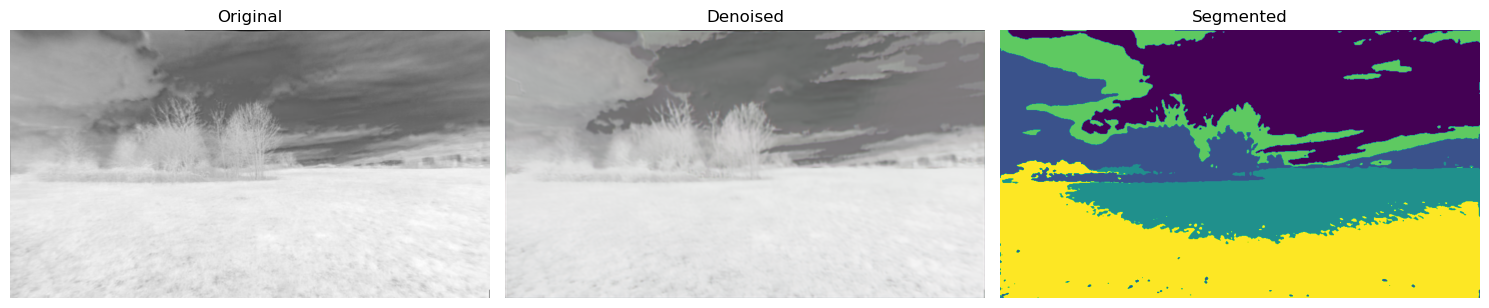

In [12]:
# Evaluation and visualization
with torch.no_grad():
    for images, _ in dataloader:
        images = images.to(device)
        denoised_images = model(images)
        
        # Move tensors to CPU and convert to numpy arrays
        original_image = images[0].cpu().numpy().transpose(1, 2, 0)
        denoised_image = denoised_images[0].cpu().numpy().transpose(1, 2, 0)
        
        # Perform segmentation
        segmented_image = segment_image(denoised_image)
        
        # Visualize result
        visualize_results(original_image, denoised_image, segmented_image)
        
        break


In [11]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

DenoisingCNN(
  (encoder): Sequential(
    (0): Conv2d(30, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(64, 30, kernel_size=(3, 3), stride=(1, 1), padding=(